# Astrometric analysis with ePSF

## Importing some modules

In [16]:
import copy, warnings
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
from astropy.modeling import models, fitting
from astropy.nddata import NDData
from astropy.stats import sigma_clipped_stats
from astropy.table import Table
from astropy.visualization import simple_norm
from photutils.background import MMMBackground
from photutils.detection import find_peaks
from photutils.psf import EPSFBuilder, extract_stars

## Defining a function

In [17]:
def func(filename, sp_filename):
    '''
    filename: Name of the input FITS file.
    sp_filename: Name of the input star-plate file.
    '''
    
    mask_size = 25   # Edge mask size.
    ext_size  = 9    # Size of extraction window.
    n_oversample = 4 # Number of oversampling for ePSF.
    n_maxiter    = 3 # Max. number of iteration for making ePSF.

    print("Analyzing {}...".format(filename))
    
    # Loading image.
    hdu = pf.open(filename)[0]
    data = hdu.data.astype(np.float32)
    norm = simple_norm(data, 'sqrt', percent=99.)
#    plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
#    plt.xlabel('X (px)')
#    plt.ylabel('Y (px)')
#    plt.show()
    
    # Finding peaks.
    peaks_tbl = find_peaks(data, threshold=300.)
    peaks_tbl['peak_value'].info.format = '%.8g'  # for consistent table output
#    print(peaks_tbl)
    
    # Removing detections near edge.
    hsize = (mask_size - 1) / 2
    x = peaks_tbl['x_peak'] 
    y = peaks_tbl['y_peak'] 
    mask = ((x > hsize) & (x < (data.shape[1] -1 - hsize)) &
            (y > hsize) & (y < (data.shape[0] -1 - hsize)))
    stars_tbl = Table()
    stars_tbl['x'] = x[mask]
    stars_tbl['y'] = y[mask]
#    print(stars_tbl)
    
    # Subtracting background.
    mean_val, median_val, std_val = sigma_clipped_stats(data, sigma=2.)  
    image = copy.deepcopy(data)
    data -= mean_val
#    plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
#    plt.xlabel('X (px)')
#    plt.ylabel('Y (px)')

    # Extracting stellar images.
    nddata = NDData(data=data)
#    print(nddata.data.shape)
    stars = extract_stars(nddata, stars_tbl, size=ext_size)
#    nrows = 10
#    ncols = 10
#    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20), squeeze=True)
#    ax = ax.ravel()
#    for i in range(nrows*ncols):
#        norm = simple_norm(stars[i], 'log', percent=99.)
#        ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')
#    plt.show()
        
    # Making ePSF.
    epsf_builder = EPSFBuilder(oversampling=n_oversample,
                               maxiters=n_maxiter, progress_bar=True)
    epsf, fitted_stars = epsf_builder(stars)
    norm = simple_norm(epsf.data, 'log', percent=99.)
    plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
    plt.xlabel('X (oversampled pix)')
    plt.ylabel('Y (oversampled pix)')
    plt.colorbar()
    plt.show()

    # Loading stellar-plate data.
    original = np.loadtxt(sp_filename,skiprows=1,delimiter=",")
    
    # Cross-checking the data.
    xc_array = []
    for o in original:
        diff = fitted_stars.center_flat-np.array([o[2],o[3]])
        p = np.where(diff[:,0]**2.+diff[:,1]**2.<10.**2.)
        if np.size(p) == 1:
            xc_array.append([o[2], o[3],
                             fitted_stars.center_flat[p[0][0]][0],
                             fitted_stars.center_flat[p[0][0]][1]])
    xc_array = np.array(xc_array)
#    print(xc_array)
    
    # Making dx/dy data.
    dx = xc_array[:,2] - xc_array[:,0]
    dy = xc_array[:,3] - xc_array[:,1]
    dx = dx - np.mean(dx)
    dy = dy - np.mean(dy)
    plt.scatter(dx, dy)
    plt.xlabel('$\Delta$x (px; w/o global offset)')
    plt.ylabel('$\Delta$y (px; w/o global offset)')
    plt.show()
    
    plt.axes().set_aspect('equal')
    plt.quiver(xc_array[:,2], xc_array[:,3], dx, dy,
               angles='xy', scale_units='xy', scale=0.0003)
    plt.xlabel('X (px)')
    plt.ylabel('Y (px)')
    plt.xlim([0, 1920])
    plt.ylim([0, 1920])
    plt.show()
    
    # Calculating stddev.
#    print("STDDEV DX: {} px".format(np.std(dx)))
#    print("STDDEV DY: {} px".format(np.std(dy)))
    stddx = np.std(dx)
    stddy = np.std(dy)
    stddr = np.std(np.sqrt(dx*dx+dy*dy))
    return stddx, stddy, stddr

Analyzing image00.fits...


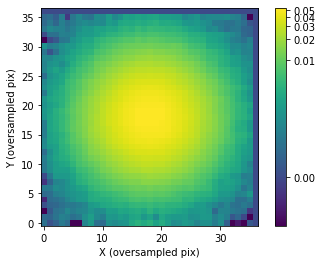

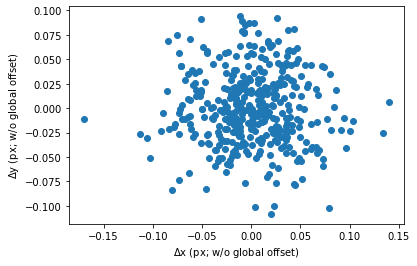

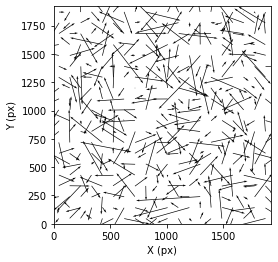

Analyzing image01.fits...


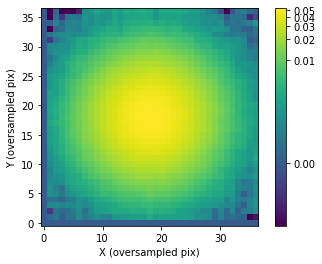

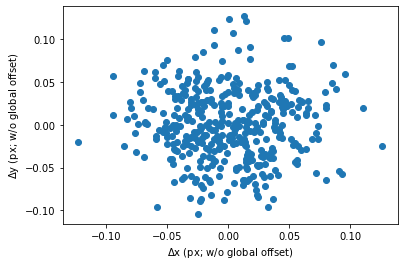

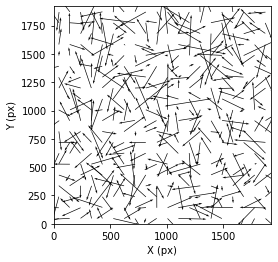

Analyzing image02.fits...


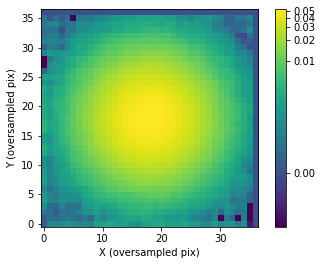

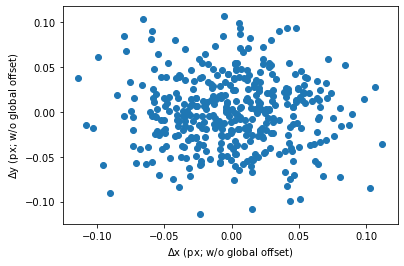

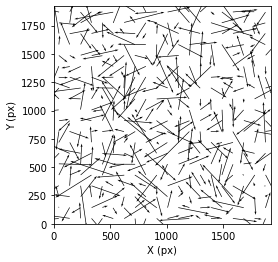

Analyzing image03.fits...


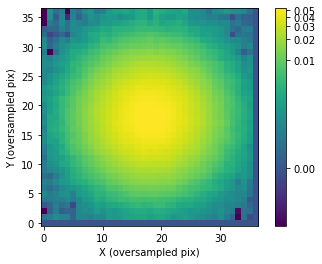

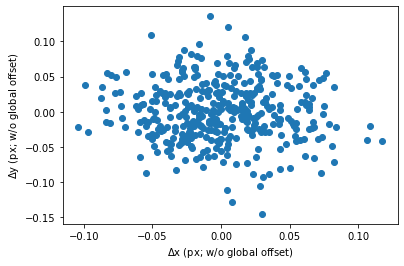

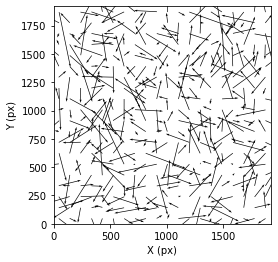

Analyzing image04.fits...


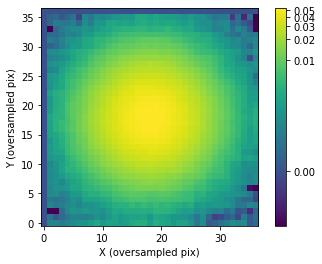

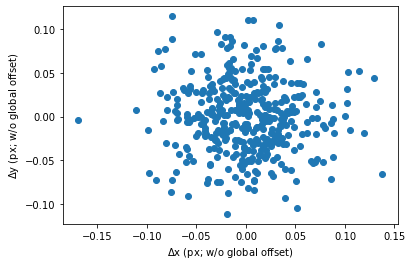

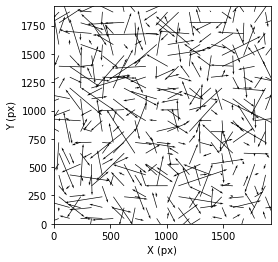

Analyzing image05.fits...


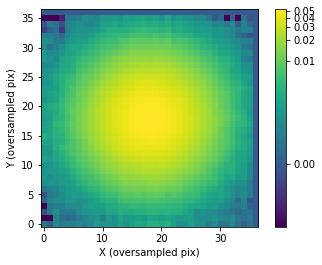

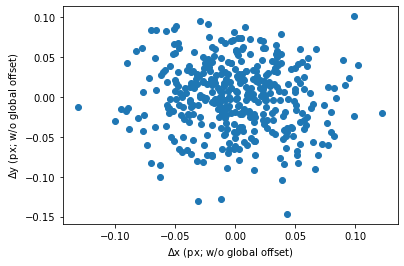

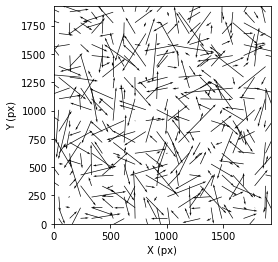

Analyzing image06.fits...


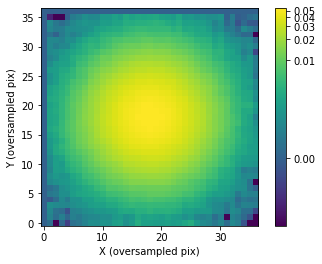

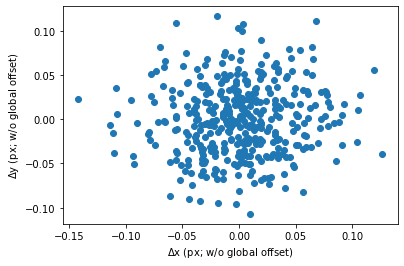

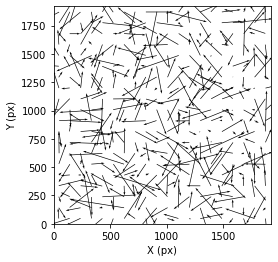

Analyzing image07.fits...


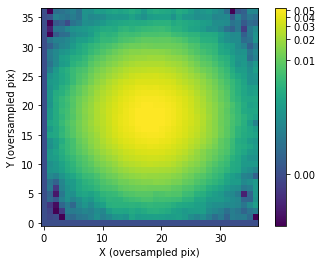

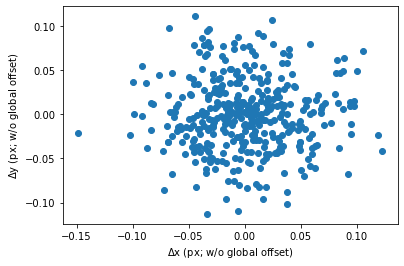

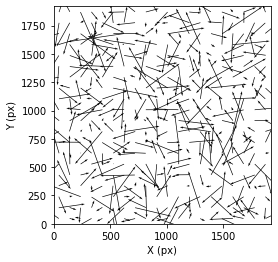

Analyzing image08.fits...


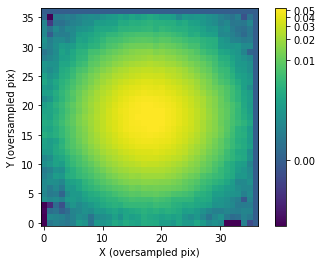

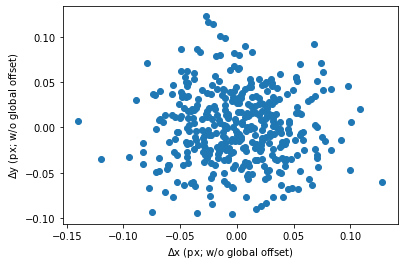

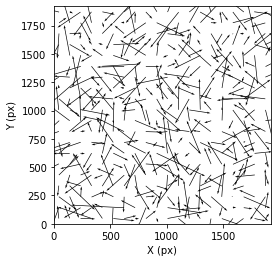

Analyzing image09.fits...


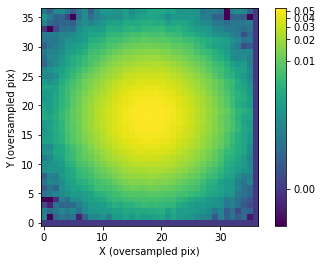

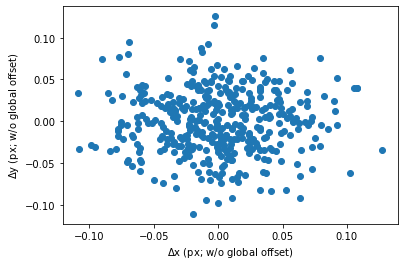

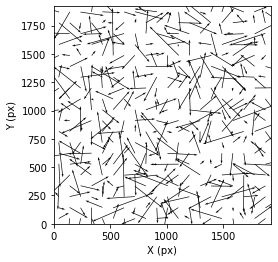

Analyzing image10.fits...


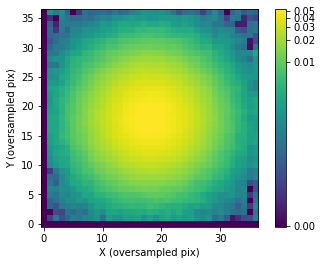

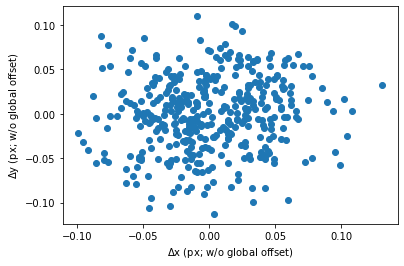

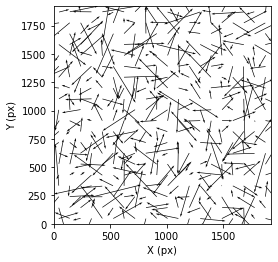

In [18]:
sra=[]
for i in range(0,11):
    sx, sy, sr = func("image{:02d}.fits".format(i),
                      "../../01_params/spcsv_20_1920_10_20_12.0.csv")
    sra.append(sr)

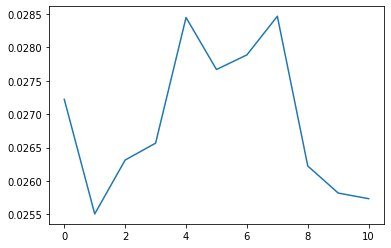

In [19]:
plt.plot(sra)

In [20]:
print("Accuracy: {:7.5f} p/m {:7.5f} px".format(np.mean(sra),
                                                np.std(sra,ddof=1)/np.sqrt(np.size(sra))))

Accuracy: 0.02690 p/m 0.00033 px
